In [3]:
import pickle
import random
from sklearn.linear_model import LinearRegression

import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np

from scipy.stats import beta

import matplotlib.pyplot as plt

from agents import hateAgent
from misinfo_functions import (
    generate_params_dict,
    step_params_dict,
    calc_energy,
    acceptance_proba,
    make_agent_info_dict,
    update_agent_info,
    choose_orientation,
    getList_ofkeys,
)
from utilities import markov_update_log, make_configuration_model_graph




In [4]:
""""
Robin's hate attempt


things I've added:
hatefulness - similar to misinfo belief, its the hatefulness of beliefs that ppl have 
    goes from - 10 to pos 10 negative being having counter hateful beliefs

shares_hate  - basically shares but for hatefulness, but people only share if they are hateful

hate_orientation - basically if they are hateful (1), counter hateful (2) or neutral (0)
removed exposed  

to start off with i'll have 3% be hateful, 3% are counterhateful the rest will be nuetral 94%
    - He. et al. (2021)
"""



def run_agent_simulation_now_with_added_hate(N_AGENTS, params_dict):
    """
    Given a number of agents & parameters for constructing the simulation,
    run a 100-round simulation of belief updating w/ Bayesian agents.
    
    Returns info on each agent's parameters, sharing for each agent each round, and centrality info for each agent.
    """
    agents = []

    hate_agents = params_dict["hate_agents"]
    counter_hate_agents = params_dict["counter_hate_agents"]

    for i in range(N_AGENTS): # creats the start parameters for each of the agents 
        #each agent gets one of these 
        #if statements are so that hate agents start out hateful and counter hateful agents are not
        if i in hate_agents:
            agent = hateAgent(
                agent_id=i,
                neighbors={},
                forcefulness=np.log(
                    np.random.beta(params_dict["B1_START_FO"], params_dict["B2_START_FO"])
                ),
                share_propensity=np.log(
                    np.random.beta(params_dict["B1_START_SP"], params_dict["B2_START_SP"])
                ),
                misinfo_belief=np.log(
                    np.random.beta(params_dict["B1_START_MB"], params_dict["B2_START_MB"])
                ),
                trust_stability=np.log(
                    np.random.beta(params_dict["B1_START_TS"], params_dict["B2_START_TS"])
                ),
                hatefulness=(
                    np.random.uniform(params_dict["B1_START_Hate_Hatefulnes"], params_dict["B2_START_Hate_Hatefulnes"])
                ),
                hate_orientation= choose_orientation(i, hate_agents,counter_hate_agents)
            )
            # give the hate and counter hate agents a certain amount of hate
            
            agents.append(agent)
        elif i in counter_hate_agents:
            agent = hateAgent(
                agent_id=i,
                neighbors={},
                forcefulness=np.log(
                    np.random.beta(params_dict["B1_START_FO"], params_dict["B2_START_FO"])
                ),
                share_propensity=np.log(
                    np.random.beta(params_dict["B1_START_SP"], params_dict["B2_START_SP"])
                ),
                misinfo_belief=np.log(
                    np.random.beta(params_dict["B1_START_MB"], params_dict["B2_START_MB"])
                ),
                trust_stability=np.log(
                    np.random.beta(params_dict["B1_START_TS"], params_dict["B2_START_TS"])
                ),
                hatefulness=(
                    np.random.uniform(params_dict["B1_START_Counter_Hatefulnes"], params_dict["B2_START_Counter_Hatefulnes"])
                ),
                hate_orientation= choose_orientation(i, hate_agents,counter_hate_agents)
            )
            # give the hate and counter hate agents a certain amount of hate
            
            agents.append(agent)
        else:
            agent = hateAgent(
                agent_id=i,
                neighbors={},
                forcefulness=np.log(
                    np.random.beta(params_dict["B1_START_FO"], params_dict["B2_START_FO"])
                ),
                share_propensity=np.log(
                    np.random.beta(params_dict["B1_START_SP"], params_dict["B2_START_SP"])
                ),
                misinfo_belief=np.log(
                    np.random.beta(params_dict["B1_START_MB"], params_dict["B2_START_MB"])
                ),
                trust_stability=np.log(
                    np.random.beta(params_dict["B1_START_TS"], params_dict["B2_START_TS"])
                ),
                hatefulness=(
                    np.random.uniform(params_dict["B1_START_Hatefulness"], params_dict["B2_START_Hatefulness"])
                ),
                hate_orientation= choose_orientation(i, hate_agents,counter_hate_agents)
            )
            # give the hate and counter hate agents a certain amount of hate
            
            agents.append(agent)

    # G, agents = make_er_graph(0.05, N_AGENTS, agents)
    G, agents = make_configuration_model_graph(N_AGENTS, 2.5, agents, params_dict)

    centrality = sorted(
        [(k, v) for k, v in nx.closeness_centrality(G).items()], key=lambda b: b[0]
    )

    centrality = np.array([c[1] for c in centrality]).reshape(-1, 1) # gets the centrality for each agent 
    agent_records = {a.agent_id: {} for a in agents} #creates the agent records
    shares = {a.agent_id: {} for a in agents} #creates the number of shares in agent records
    shares_hate = {a.agent_id: {} for a in agents} 
    hate_orientation_time = {a.agent_id: {} for a in agents} #creates the orientation time keeper 
    hatefulness_time = {a.agent_id: {} for a in agents} #creates the orientation time keeper 

    # from multiprocessing import Pool
    # pool = Pool(8)

    #records - everything
    #agent info dict - just the most previous timestep 
    for time_step in range(250):
        for agent in agents:
            agent_records[agent.agent_id][time_step] = { #creates a dictionary in agent records where the agent id and time step record the trust, misinfo beleif and share propensity 
                "neighbor_trust": agent.neighbors,
                "misinfo_belief": agent.misinfo_belief,
                "share_propensity": agent.share_propensity,
                "hatefulness": agent.hatefulness,
            }

            

        neighbor_beliefs = [ # gets the neighbor beliefs 
            [(i, agents[i].misinfo_belief) for i in agent.neighbors.keys()]
            for agent in agents
        ]
        neighbor_beliefs_hate = [ # gets the neighbor beliefs 
            [(i, agents[i].hatefulness) for i in agent.neighbors.keys()]
            for agent in agents
        ]
        neighbor_forcefulness = [
            [agents[i].forcefulness for i in agent.neighbors.keys()] for agent in agents
        ]
        neighbor_orientation = [
            [agents[i].hate_orientation for i in agent.neighbors.keys()] for agent in agents
        ]
        
        agent_info_dicts = [  #the most recent agent info, agent records goes all the way back 
            make_agent_info_dict(a, b, f, h, ho, params_dict)
            for a, b, f, h, ho in zip(agents, neighbor_beliefs, neighbor_forcefulness,neighbor_beliefs_hate, neighbor_orientation)
        ]
        
        res = map(update_agent_info, agent_info_dicts) # map means you apply the function to every item in agent info dicts 
        for r, agent in zip(res, agents): #r is the updated agent information 
            # so this updates all of the info for the agents, its a dictionary 
            agent.neighbors = r["neighbor_trust"]
            agent.misinfo_belief = r["misinfo_belief"]
            agent.share_propensity = r["share_propensity"]
            
            shares[agent.agent_id][time_step] = r["shares"]

            #newstuff
            shares_hate[agent.agent_id][time_step] = r["shares_hate"] # to scrap 
            agent.hatefulness = r["hatefulness"]
            agent.hate_orientation = r["hate_orientation"]
            hate_orientation_time[agent.agent_id][time_step] = r["hate_orientation"]
            hatefulness_time[agent.agent_id][time_step] = r["hatefulness"]


    return agents, shares, centrality, hate_orientation_time, hatefulness_time


def p_x_y_hate(agents, hate_orientation_time, centrality, alpha):
    """
    For a set of Bayesian agents at the end of a simulation,
    plus their sharing results & centrality metrics, report 
    the loss of the dataset relative to reality
    
    (note that reality is currently somewhat made up)
    alpha is a scaling parameter.
    
    Returns sum of loss fns, each raised to alpha then divided by alpha

    to do add quanitative info 
    """
    loss = 0.0
    # shared = [np.sum([v for v in shares_hate[a.agent_id].values()]) for a in agents]
    # shared_by_id = [
    #     (a.agent_id, np.sum([v for v in shares[a.agent_id].values()])) for a in agents
    # ]
    # shared_by_id = sorted(shared_by_id, key=lambda b: b[0])
    # shared_by_id = [s[1] for s in shared_by_id]
    # find correlation between sharing and centrality,
    # with the assumption that more central nodes share more.
    # we need to get a quantitative measurement for this.

    final_hatefulness = []
    for i in range(100):
        final_hatefulness.append(hate_orientation_time[i][249])
    hatefulness_by_id = [
        (a.agent_id, (final_hatefulness[a.agent_id])) for a in agents
    ]
    
    reg = LinearRegression().fit(centrality,final_hatefulness)
    centrality_to_n_shared_model = reg.coef_[0]
    centrality_to_n_shared_real = 0.5 # arbitrary guess
    loss += np.abs(centrality_to_n_shared_model - centrality_to_n_shared_real) ** alpha
    
    #find out how many agents there were by each type 
    number_counter = final_hatefulness.count(2)
    percentage_counter = number_counter/len(agents)
    percentage_counter_real = 0.3 #made this up for testing
    loss += np.abs(percentage_counter - percentage_counter_real) ** alpha

    number_hateful = final_hatefulness.count(1)
    percentage_hatefulness = number_hateful/len(agents)
    percentage_hatefulness_real =0.3 #made up for testing 
    loss += np.abs(percentage_hatefulness - percentage_hatefulness_real) ** alpha

    # # find out how much misinfo was shared by the top 1% of misinfo sharers
    # # using L1 loss here.
    # shared_by_top_one_percent_model = np.sum(
    #     sorted(shared)[-int(0.01 * len(shared)) :]
    # ) / (1 + np.sum(shared))
    # shared_by_top_one_percent_real = 0.8 # info from lazer lab twitter metrics
    # loss += np.abs(shared_by_top_one_percent_model - shared_by_top_one_percent_real) ** alpha

    # # find out how much sharing per capita occurred
    # # again using L1 loss
    # n_shared_per_capita_model = np.sum(shared) / len(agents)
    # n_shared_per_capita_real = 1.0
    # loss += np.abs(n_shared_per_capita_model - n_shared_per_capita_real) ** alpha
    
    return loss / alpha
    
    
def G_func(my_ensemble_P, x):
    """
    Get smoothed probability of a simulation outcome x
    given my_ensemble_P, which is an ensemble of simulation outcomes
    generated from the overall distribution.
    """
    # make fancier later? right now assumes constant prior (the horror)
    constant_proba = np.log(0.1) * 10 + np.log(0.01) * 2
    candidates = [np.exp(constant_proba) for tup in my_ensemble_P if tup[1] <= x]
    return np.sum(candidates)

In [5]:
final_hatefulness = []
for i in range(100):
    final_hatefulness.append(hate_orientation_time[i][249])

#print(final_hatefulness)
hatefulness_by_id = [
    (a.agent_id, (final_hatefulness[a.agent_id])) for a in agents
]
#print(hatefulness_by_id)

#reg = LinearRegression().fit(centrality, shared)
# reg = LinearRegression().fit(centrality,final_hatefulness)
# print(reg)
LinearRegression().fit(centrality,final_hatefulness)



NameError: name 'hate_orientation_time' is not defined

In [44]:
shared = [np.sum([v for v in shares[a.agent_id].values()]) for a in agents]
shared_by_id = [
    (a.agent_id, np.sum([v for v in shares[a.agent_id].values()])) for a in agents
]
#reg = LinearRegression().fit(centrality, shared)
#print(shares)
print(shared)
print(shared_by_id)

[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1]
[(0, 1), (1, 0), (2, 0), (3, 0), (4, 1), (5, 0), (6, 1), (7, 0), (8, 0), (9, 0), (10, 1), (11, 1), (12, 1), (13, 0), (14, 1), (15, 0), (16, 1), (17, 1), (18, 1), (19, 0), (20, 0), (21, 0), (22, 2), (23, 0), (24, 1), (25, 2), (26, 0), (27, 1), (28, 1), (29, 0), (30, 1), (31, 0), (32, 1), (33, 0), (34, 1), (35, 2), (36, 0), (37, 2), (38, 0), (39, 1), (40, 1), (41, 1), (42, 0), (43, 1), (44, 0), (45, 1), (46, 0), (47, 2), (48, 0), (49, 1), (50, 0), (51, 0), (52, 1), (53, 0), (54, 0), (55, 2), (56, 0), (57, 1), (58, 1), (59, 1), (60, 0), (61, 0), (62, 1), (63, 0), (64, 0), (65, 1), (66, 1), (67, 1), (68, 0), (69, 0), (70, 1), (71, 0), (72, 0), (73, 1), (74, 0), (75, 0), (76, 1), (77, 1), (78, 1

[]


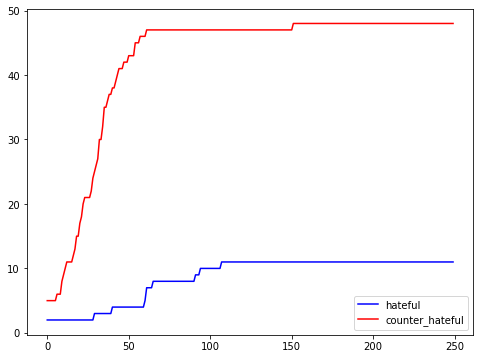

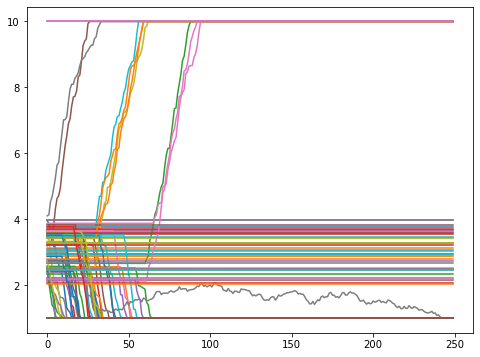

In [6]:
params_dict = generate_params_dict()
N_AGENTS = 100 
agents, shares, centrality, hate_orientation_time, hatefulness_time = run_agent_simulation_now_with_added_hate(N_AGENTS, params_dict)
def returnSum_1(dict):
     # quick dictionary adder to get the infection curves of the hateful and counterhateful ppl
    sum_1 = 0
    sum_2 = 0 
    for i in dict:
        if dict[i] == 1:
            sum_1 += 1
        if dict[i] == 2:
            sum_2 += 1
      
    return sum_1, sum_2


#print(returnSum_1(hate_orientation_time))

#print(hate_orientation_time)

hateful_infection = []
counter_hateful_infection = []
# for num in range(N_AGENTS):  
#     sum1, sum2 = returnSum_1(hate_orientation_time[num])
#     hateful_infection.append(sum1)
#     counter_hateful_infection.append(sum2)

sum1 = 0
sum2 = 0
for num in range(250):  
    for num2 in range(N_AGENTS):
        if hate_orientation_time[num2][num] == 1:
            sum1 += 1
        if hate_orientation_time[num2][num] == 2:
            sum2 += 1
    
    hateful_infection.append(sum1)
    counter_hateful_infection.append(sum2)
    sum1 = 0
    sum2 = 0

fig, ax = plt.subplots(figsize = (8,6))

ax.plot( range(250), hateful_infection, label = "hateful", color = "b")
ax.plot( range(250), counter_hateful_infection, label = "counter_hateful", color = "r")
ax.legend()

hateful_infection = []
counter_hateful_infection = []
hatefulness_time_dict = [ [] for a in range(N_AGENTS) ]

sum1 = 0
sum2 = 0
for num in range(250):  
    for num2 in range(N_AGENTS):
        hatefulness_time_dict[num2].append(hatefulness_time[num2][num])



fig, ax = plt.subplots(figsize = (8,6))
for num in range(N_AGENTS):
    ax.plot( range(250), hatefulness_time_dict[num], label = "BA Graph")

print(hateful_infection)


In [65]:
# setting up simulation. 
N_AGENTS = 100
ALPHA = 2.5
EPSILON_INIT = 0.5
rnd_info = []

ensemble_P = []
ensemble_E = []

"""
Robin notes

sp threshold is the threshold an agent needs to have to share misinfo 
"""


# burn-in period (kind of) - getting ensemble_E, 
# which is the fairly likely set of parameter -> outcome items.
while len(ensemble_E) < 100:
    if len(ensemble_E) % 5 == 0 and len(ensemble_E) != 0:
        print(len(ensemble_E))
        
    params_dict = generate_params_dict()
    agents, shares, centrality, hate_orientation_time, hatefulness_time = run_agent_simulation_now_with_added_hate(N_AGENTS, params_dict)
    tup = (params_dict, p_x_y_hate(agents, hate_orientation_time, centrality, ALPHA))
    if tup[1] == 0:
        print("weird")
    proba_p = np.exp(-1.0 * tup[1]/ EPSILON_INIT)
    print("proba_p",proba_p)
    draw = np.random.uniform()
    if draw < proba_p:
        ensemble_E.append(tup)
        # if it's a good draw compared to the overall "background" ensemble,
        # we will likely add it to ensemble_E. 
        print("goodnews")
    ensemble_P.append(tup)
    #print(len(ensemble_E))
    


proba_p 3.617180970081117e-93
proba_p 0.14962167256350142
proba_p 1.8351238332255147e-38
proba_p 0.0
proba_p 6.298834719149366e-12
proba_p 1.3871348238567233e-246
proba_p 5.4782130333386686e-67
proba_p 0.0
proba_p 1.346478099647095e-99
proba_p 0.8977014535651195
goodnews
proba_p 3.2078333091427274e-13
proba_p 1.2585685357364306e-69
proba_p 0.00011351150107283893
proba_p 1.9860437178226494e-100
proba_p 0.017734408888717298
proba_p 1.3002345996533764e-27
proba_p 1.4058259152859003e-06
proba_p 9.635354831446655e-84
proba_p 0.0
proba_p 1.5476531179805348e-37
proba_p 1.5466101266714818e-06
proba_p 0.0
proba_p 7.808065941048284e-69
proba_p 0.0
proba_p 1.0026486484873653e-20
proba_p 3.6161578142737143e-35
proba_p 8.483701002023951e-13
proba_p 2.4231802292102087e-06
proba_p 3.876267724129638e-14
proba_p 0.0
proba_p 5.789674352542403e-25
proba_p 3.624249646628627e-53
proba_p 2.0659324813751064e-19
proba_p 1.7408761460188082e-05
proba_p 0.0
proba_p 7.4551016518147185e-53
proba_p 2.09503993598357

In [2]:
# smoothed probabilities for items in ensemble_P
G_result = [G_func(ensemble_P, tup[1]) for tup in ensemble_P]
# the starting "good" ensemble of predictions
ensemble_E = [(tup[0], G_func(ensemble_P, tup[1])) for tup in ensemble_E]
U = np.mean(G_result)

EPSILON = EPSILON_INIT
t = 1
swap_rate = 0
tries = 0 #10000 to stop the simulation
while True:
    # we choose a random item in ensemble_E 
    # and generate a new set of parameters & its simulation outcome.
    # if our new item is better than the item in ensemble E,
    # we swap the old item with the new item w/ high probability.
    chosen_one = random.choice([i for i in range(len(ensemble_E))])   
    particle, u = ensemble_E[chosen_one] # u is the goodness of fit, and particle is a dictionary of simulation settings 
    proposal = generate_params_dict()
    agents, shares, centrality, hate_orientation_time, hatefulness_time = run_agent_simulation_now_with_added_hate(N_AGENTS, params_dict)
    proba_star = p_x_y_hate(agents, hate_orientation_time, centrality, ALPHA)
    u_star = G_func(ensemble_P, proba_star)
    
    proba_swap = min(1.0, np.exp(-1.0 * (u_star - u)) / np.exp(EPSILON))
    tries += 1
    if np.random.uniform() < proba_swap:
        swap_rate += 1
        ensemble_E[chosen_one] = (proposal, u_star)

    EPSILON = t ** (0.1)
    # we keep doing this until our continuous swap rate
    # drops below a threshold (0.05) - in that case, 
    # we're rejecting most items so we should give up.
    if t % 10 == 0:
        print(swap_rate / tries)
    if t % 1000 == 0:
        # dumps items to file for future analysis.
        pickle.dump(ensemble_E, open('ensemble_E_{}.pkl'.format(str(t)), 'wb'))
    t += 1
    if (swap_rate / tries) < 0.05 and tries > 20:
        break


# look for it to decrease slowly and if it increases or decreases fast that is a problem 
#the more we are swapping out, then more it means that our ensemble wasnt very good 
# so if its replacing a lot that means our ensemble is bad/ suspicious 

NameError: name 'ensemble_P' is not defined

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


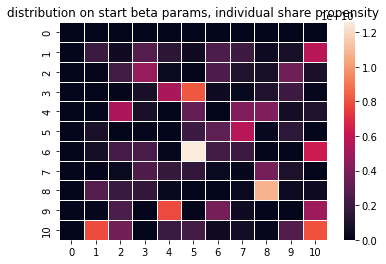

In [166]:
# just some visualizations down here.
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_e/ensemble_E_171900.pkl', 'rb')) # latest param set
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_SP']) + '_' + str(e[0]['B2_START_SP']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_SP'] == i and e[0]['B2_START_SP'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual share propensity')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


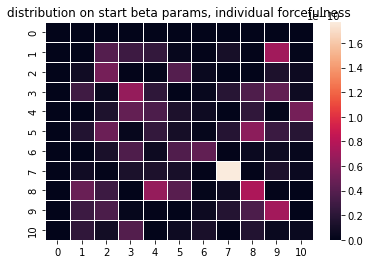

In [162]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_E_42900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_FO']) + '_' + str(e[0]['B2_START_FO']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_FO'] == i and e[0]['B2_START_FO'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual forcefulness')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


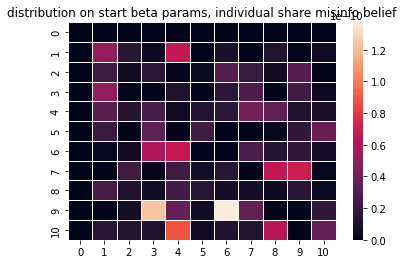

In [164]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_E_42900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_START_MB']) + '_' + str(e[0]['B2_START_MB']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_START_MB'] == i and e[0]['B2_START_MB'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual share misinfo belief')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

dict_keys(['B1_NTRUST', 'B2_NTRUST', 'B1_START_MB', 'B2_START_MB', 'B1_START_FO', 'B2_START_FO', 'B1_START_SP', 'B2_START_SP', 'B1_START_TS', 'B2_START_TS', 'NTRUST_THRESHOLD', 'SP_THRESHOLD'])


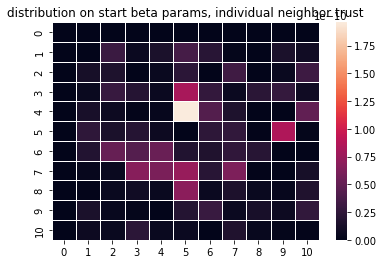

In [161]:
import numpy as np
import collections
import seaborn as sns
ensemble_Ee = pickle.load(open('ensemble_E_42900.pkl', 'rb'))
print(ensemble_Ee[0][0].keys())
spt_th = collections.Counter([str(e[0]['B1_NTRUST']) + '_' + str(e[0]['B2_NTRUST']) for e in ensemble_Ee])
a = np.zeros((11, 11))
b = np.zeros((11, 11))
c = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i, j] = spt_th[str(i) + '_' + str(j)] 
        b[i, j] = np.sum([e[1]  for e in ensemble_Ee if e[0]['B1_NTRUST'] == i and e[0]['B2_NTRUST'] == j])
        c[i, j] = a[i, j] * b[i, j]
plt.title('distribution on start beta params, individual neighbor trust')
ax = sns.heatmap(c, linewidth=0.5)
plt.show()

(array([26., 18., 19., 20., 22., 19., 15., 21., 18., 22.]),
 array([0.01547743, 0.11323817, 0.21099891, 0.30875964, 0.40652038,
        0.50428112, 0.60204185, 0.69980259, 0.79756333, 0.89532407,
        0.9930848 ]),
 <BarContainer object of 10 artists>)

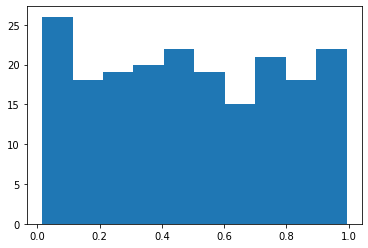

In [4]:
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.1
N = 100000

def truncated_normal():
    return scipy.stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

d = pickle.load(open('rnd_info_30.pkl', 'rb'))
d[0]['params_dict']

{'B1_NTRUST': 4,
 'B2_NTRUST': 8,
 'B1_START_MB': 5,
 'B2_START_MB': 2,
 'B1_START_FO': 10,
 'B2_START_FO': 10,
 'B1_START_SP': 3,
 'B2_START_SP': 5,
 'B1_START_TS': 10,
 'B2_START_TS': 9,
 'NTRUST_THRESHOLD': 0.41937188649018664,
 'SP_THRESHOLD': 0.46966543126877486}

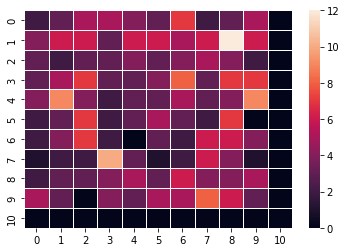

In [101]:
import numpy as np
import collections
import seaborn as sns
d = pickle.load(open('rnd_info_410.pkl', 'rb'))
spt_th = collections.Counter([str(dd['params_dict']['B1_START_MB']) + '_' + str(dd['params_dict']['B2_START_MB']) for dd in d])
a = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        a[i - 1, j - 1] = spt_th[str(i) + '_' + str(j)] 
ax = sns.heatmap(a, linewidth=0.5)
plt.show()


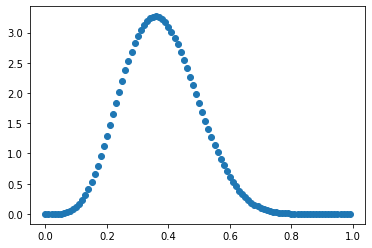

In [113]:
import scipy
xs = [0.01 * i for i in range(100)]
ys = scipy.stats.beta(6, 10).pdf(xs)
plt.scatter(xs, ys)

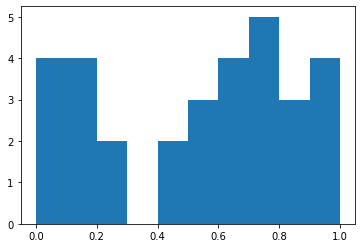

In [54]:
d = pickle.load(open('rnd_info_30.pkl', 'rb'))
spt = [dd['params_dict']['SP_THRESHOLD'] for dd in d]
plt.hist(spt)
plt.show()

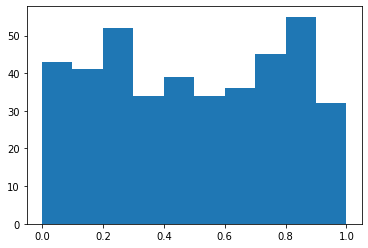

In [100]:
d = pickle.load(open('rnd_info_410.pkl', 'rb'))
spt = [dd['params_dict']['SP_THRESHOLD'] for dd in d]
plt.hist(spt)
plt.show()